In this post I'm going to tackle the question of how to go about taking the Fourier transform a stream of data when you aren't allowed to keep any more than the most recent K data points in memory, but must be able to estimate the spectral power at frequencies much lower than 1/K. 

<!-- TEASER_END -->

You might be wondering in what situations I would care to do such a thing. Normally if you want to decompose a long stream of data into its component frequencies you would take the fast fourier transform (FFT). The transform takes just $\mathcal{O}({\rm N})$ memory and just $\mathcal{O}({\rm N~log(N)})$ operations to compute and gives a perfect lossless version of the information in your original data. 

But what if you don't have the memory to keep all ${\rm N}$ points available for the FFT computation? Or even if you technically have the memory available what if you only want the FFT of the most recent $K$ points of a real time stream. If you recompute the FFT for each and every new time point then suddenly even the relatively low computational cost of the fast Fourier transform starts to look kind of expensive taking $\mathcal{O}(Klog(K)N)$ time to compute over the lifetime of the process. Whereas a <a href=https://www.dsprelated.com/showarticle/776.php> sliding DFT </a> will take just $\mathcal{O}(KN)$ time to compute. 

To give you a little motivating context I am developing this technique with a specific application in mind. A little over a year ago I was playing with different ways of sonifying the training process of a neural network. That turned out to be a deeper rabbit hole than I wanted it to be and the post never made it into a publishable state. To do this I wanted to estimate the frequency spectrum of the updates to every parameter in the network which even for relatively small networks is millions of parameters. Keeping the historical parameter values around for each and every batch is obviously a little memory intensive (to put it mildly). I decided it would be ideal if I could keep a streaming estimate of the spectral update signature, so I started developing the streaming update techniques. I'm still not certain if they are really useful for network sonification purposes but I think the idea itself is worth a little exposition. Since I'm rescuing parts of old losts posts for <a href=blogging-blitz-2019.html> the blitz </a> I decided I would make a whole post devoted to the question of trying to keep a spectral summary of a continuous valued data stream updated one point at a time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":16,
    }
)

## Generating a Chirp

In order to make sure that the algorithms we explore are working properly it is nice to have a test signal which is simple enough to be able to see what the right answer is but not so simple that we can't see weaknesses in our spectral estimators. For now we will just make a chirp that begins at a high frequency and sweeps down to lower frequencies over time. 

We will use a log-linear frequency sweep since that makes for a good diagnostic chirp both from an algorithmic perspective and a human one. 

In [3]:
duration = 3.0
t = np.linspace(0, duration, int(22050*duration))
max_freq = 8000
min_freq = 20
f_of_t = np.exp(np.linspace(np.log(max_freq), np.log(min_freq), len(t)))
dt = t[1]-t[0]
random_start_phase = np.random.uniform(-np.pi, np.pi)
integrated_phase = random_start_phase + np.cumsum(2.0*np.pi*f_of_t*dt)
test_signal = np.sin(integrated_phase)

## Validating The Test Signal

First thing we want to do is to make sure that we did the job of generating our chirp correctly and that we in fact have a signal which is close to having just one frequency at a given moment and whose frequency sweeps from high to low in the way I expect. 

The standard solution to determining the component frequencies of a signal as a function of time is the Short Time Fourier Transform (STFT). In an STFT you divide the data up into short windows, multiply each such data snippet by a windowing function (more about this later), and take the fast fourier transfrom on this window. 
Lucky for us there is a nice fast and stable implementation of this in the scipy.signal module, which we will use to analyze our test signal.

In [4]:
def plot_spectrogram(
    frequencies,
    times,
    spectra,
    ax=None, 
):
    if ax is None:
        fig, ax = plt.subplots()
    
    im = ax.imshow(
        np.abs(spectra),
        aspect="auto", 
        origin="lower",
        extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
    )
    cbar = plt.colorbar(im)
    cbar.set_label("Fourier Magnitude")
    ax.set_xlabel("Time [Seconds]")
    ax.set_ylabel("Frequency [Hz]")


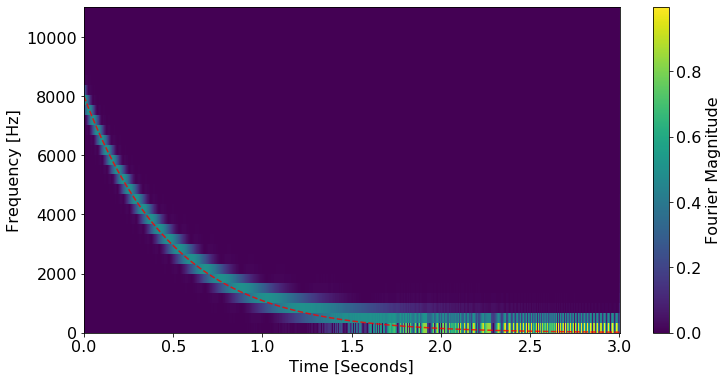

In [5]:
fft_freqs, frame_times, stft_result = scipy.signal.stft(
    test_signal,
    nperseg=64,
    fs=22050,
)

plot_spectrogram(fft_freqs, frame_times, stft_result)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);


The non-zero magnitudes are indeed centered around a tight band of frequencies which sweep from high to low frequencies over time. I've overplotted the desired frequency structure as a red dashed line, and indeed the apparent frequencies detected by the short time fourier transforms match the targeted ideal frequencies.

Something interesting to note is that as the frequency of the signal becomes low relative to the minimum resolvable frequency of the FFT the measured Fourier magnitudes become unstable. They don't simply fade smoothly towards the zero frequency bin but instead fluctuate chaotically depending on the phase of the oscilation as it overlaps with the calculation window.

# Sliding FT

Lets start with the above mentioned sliding DFT. The idea is simple the normal definition of the Fourier transform is as a sum of complex exponentials with one term per sample in the signal to be analyzed. 

If we have $N$ samples of some function of time $x_t$ we can get an estimate of the strength of oscillations of frequency f present in the signal x by evaluating the sum,

$$
\large{
\hat{a}_{f} = \frac{1}{N} \sum_{t=1}^{N} x_t~e^{-i 2 \pi tf}
}
$$

Normally it would be a terrible idea to actually implement a Fourier transform directly in terms of this sum since it is wildly inefficient relative to the more commonly used fast Fourier transform. 

However this sum formulation has a very nice side effect in that we can keep it incrementally updated. We simply subtract off the term for $x_t$ which slides out of our window and add the term for the newest value in. Nothing could be simpler, lets see how this performs.

In [6]:
class SlidingFT(object):
    
    def __init__(
        self,
        monitored_freqs,
        dt,
        window_length,
    ):
        self.dt = dt
        self.monitored_freqs = monitored_freqs
        self.window_length = window_length
        self.accumulated_phase = np.zeros(len(monitored_freqs))
        self.spectrum = np.zeros(len(monitored_freqs)) + 0j
        self._past_updates = []
    
    def update(self, new_value):
        #generate the complex exponential
        cplex_phase_vec = np.exp(-1j*self.accumulated_phase)
        #calculate the newest term in the expansion
        cwave = new_value*cplex_phase_vec
        update_val = cwave/self.window_length
        #add the update
        self.spectrum += update_val
        self._past_updates.append(update_val)
        #check if the history is long enough 
        if len(self._past_updates) > self.window_length:
            #subtract off the oldest value
            out_of_window = self._past_updates.pop(0)
            self.spectrum -= out_of_window
        
        #update the current phase for each frequency
        self.accumulated_phase += (2.0*np.pi*self.dt)*self.monitored_freqs


We will be testing a few different streaming spectrum analyzers so it will be helpful to have a function which feeds the analyzer data from our data stream and periodically captures the current state of the estimated spectrum. This is very analogous to the STFT function above and we will make it match the stft response signature with a (frequency, time, spectra) tuple so that we can treat the STFT and the streaming analyzers interchageably. 

In [7]:
def monitor_spectrum(
    analyzer,
    data,
    times,
    monitoring_period,
):
    accum_spectra = []
    frame_times = []
    for idx, value in enumerate(data):
        analyzer.update(value)
        if idx % monitoring_period == monitoring_period-1:
            frame_times.append(0.5*(times[idx]+times[max(0, idx-monitoring_period)]))
            accum_spectra.append(analyzer.spectrum.copy())
    return analyzer.monitored_freqs, frame_times, np.stack(accum_spectra, axis=1)

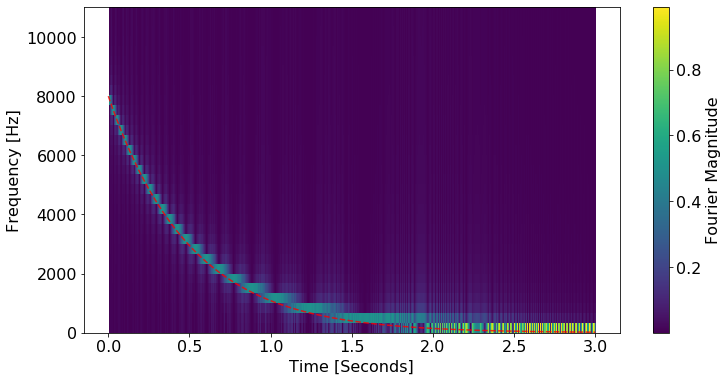

In [8]:
sft = SlidingFT(
    monitored_freqs=np.linspace(0, 11025, 33),
    dt=1/22050.0,
    window_length=64,
)

sft_spectra = monitor_spectrum(
    analyzer=sft,
    data=test_signal,
    monitoring_period=64,
    times=t,
)

plot_spectrogram(*sft_spectra)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8)


The sliding FT is definitely picking up the general gist of the structure of our chirp with a swath of maximum magnitude coefficients which roughly follows the current chirp frequency. But what are all those little vertical spikes fanning out from the main frequency locus?

The culprit here is the fact that we haven't done anything to ensure that the data inside of the recent history looks like it could be cyclical. That is the job of the windowing function which we mentioned earlier. The windowing function is a function that smoothly goes to zero at the edges and is close to 1 in the middle. Multiplying this function into the data before taking the FFT in the standard STFT technique ensures that the data looks like a cyclical function with the end smoothly transitioning back onto the start of the data in the window. 

When we carry out the FT over the small windows of the most recent history of points we aren't guaranteed that the first and last points in that history window will match in value. In fact we are practically guaranteed that the first and last values in that window will be very different from each other. Because the FT implicitly expects that the signal is an infinitely repeated version of what it sees within that time window this mismatch of the first and last points causes an apparent discontinuity and that can cause lots of trouble when interpreting a frequency spectrum.

We can manually override the nice default settings for the stft function by passing in an intentionally poor windowing function which doesn't go to zero at the edges in order to see how that affects the resultant running spectrum estimates.

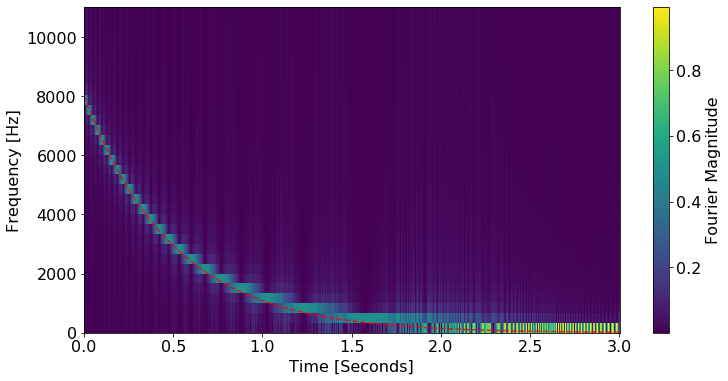

In [9]:
no_windowing_stft = scipy.signal.stft(
    test_signal,
    nperseg=64,
    fs=22050,
    window=np.ones(64),
)

plot_spectrogram(*no_windowing_stft)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);

The exact same spikes are present in the STFT. In fact these two representations should be identical to each other if we had made an effort to keep the associated data windows aligned with each other.

# Caveat Emptor

I feel like I should point out that this sliding FT tecnhique presented here has been structured in a way that intentionally allows you to create FT analyzers which are poorly performing or which have less than intuitive behavior. Normally you would not give yourself the freedom to pick any set of frequencies to monitor. The set of monitored frequencies is sort of naturally automatically chosen by the length of the window being looked at. I have only allowed arbitrary sets of monitored frequencies and window lengths because we are headed towards other algorithms for which these choices are not as black and white. 

You may have noticed that the STFT function in scipy doesn't allow you to pick which frequencies to monitor. That is because with a fixed number of sample points $N$ you can only uniquely decompose your signal onto a set of frequencies if you pick N/2+1 frequencies linearly spaced between 0 and the samplint frequency/2. Any other choice and you will be dealing with strange frequency aliasing behavior where oscilations at one frequency will bleed into the coefficients for other frequencies and/or may cause oscillations in time of the predicted frequency magnitudes. For example,

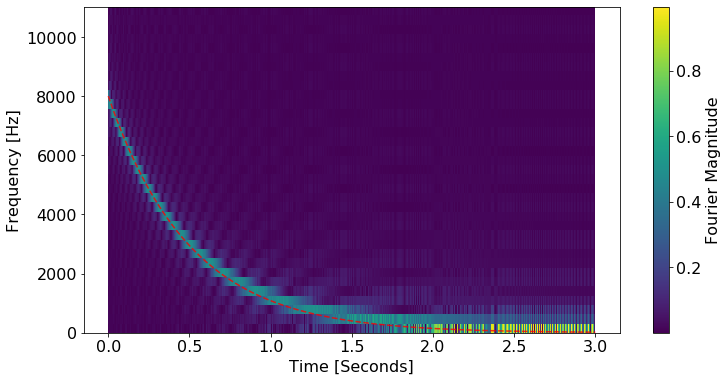

In [10]:
sft_spectra_poor_choices = monitor_spectrum(
    analyzer=SlidingFT(
        monitored_freqs=np.linspace(0, 11025, 35),
        dt=1/22050.0,
        window_length=50,
    ),
    data=test_signal,
    monitoring_period=50,
    times=t,
)

plot_spectrogram(*sft_spectra_poor_choices)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);


you might suppose that simply making the window length very long might just give you better and better estimates. But in fact it also makes your fourier estimates sensitive to only a much narrower band of frequencies and so unless you also increase the fineness of your grid of monitored frequencies you will miss oscillation power that slips in between your monitored frequencies.

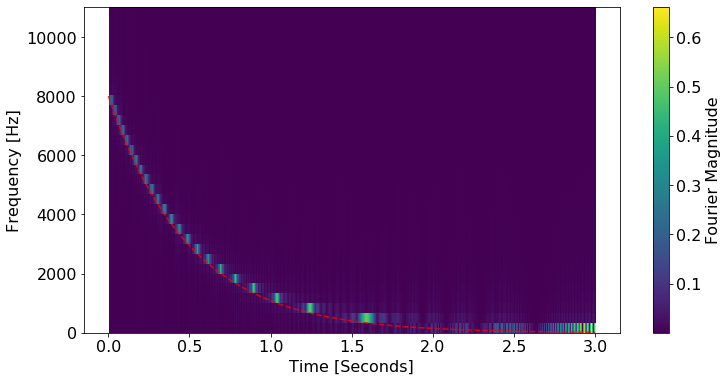

In [11]:
sft_spectra_poor_choices = monitor_spectrum(
    analyzer=SlidingFT(
        monitored_freqs=np.linspace(0, 11025, 33),
        dt=1/22050.0,
        window_length=512,
    ),
    data=test_signal,
    monitoring_period=64,
    times=t,
)

plot_spectrogram(*sft_spectra_poor_choices)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);

In the above plot we used a sliding FT with a 512 time point memory instead of just 64 time points. But because we did not also increase the fineness of the frequency grid we are monitoring we get spotty coverage. This is because with more cycles available it becoms possible to differentiate between ever finer frequencies and unless the current instantaneous frequency of the signal is close to one of our chosen monitored frequencies the signal will fall out of phase with the oscillations of the chosen frequencies and we get the sort of patchy behavior you can see above, where the frequencies don't quite match the monitored frequencies the estimated amplitude goes to zero instead of being split up amongst the closest frequencies like it was before when we had a smaller window.


The lag between the estimated frequency spectrum relative to the "true" instantaneous frequency is particularly clear in this plot. This is mostly due to the fact that when we are using the STFT method we are allowed to look into the future 1/2 a window length. This allows the frequency estimate not to lag the "instantaneous" frequency. But when using the streaming spectrum estimates we only have access to the past which naturally causes a little bit of lag.

# Exponential Moving Average 


For the sliding FT above we keep an updated estimate of the $a_f$ by subtracting off the oldest term in the sum as we add each new term in. This works pretty well if we have the necessary memory to keep around the most recent $K$ values of our signal, and we don't mind the artifacts introduced into our spectrum estimates by the wrapping discontinuities. 

But as I said at the top of this post I had in mind applications for keeping a running spectral summary on the parameters of neural networks. In reasonably large models the current model parameters might take on order 1 Gb to store. If we want to monitor oscillations over even just a few hundred parameter updates suddenly the memory requirements would be prohibitive.

Is there a way that we can get decent streaming estimates of the spectral power without keeping a running history of the data stream?

Lets take another look at the above expression for estimating Fourier coefficients.

$$
\large{
\hat{a}_{f} = \frac{1}{N} \sum_{t=1}^{N} x_t~e^{-i 2 \pi tf}
}
$$


What if instead of keeping an exact average of these terms over a window of length $N$ as we did for the sliding DFT, we instead tried to keep an exponentially smoothed average? https://en.wikipedia.org/wiki/Exponential_smoothing . Or to put it differently, instead of keeping around a sliding window of $N$ points so that we can forget each point after exactly $N$ steps why not just forget everything a just a little after each update, by decaying all the fourier coefficients towards zero.

$$
\large{
\hat{a}_{f, t+1} = \alpha~\hat{a}_{f,t} + (1-\alpha)~x[t]~e^{-i 2 \pi f t}
}
$$

or equivalently 

$$
\large{
\phi_{t} = \phi_{t-1} + 2 \pi f \\
\hat{a}_{f, t} = \alpha~\hat{a}_{f,t-1} + (1-\alpha)~x[t]~e^{-i \phi_{t}}
}
$$

In fact maybe this is even simpler than the sliding FT approach above since now there is no need to remember a history of values.

In [12]:
class ExponentialSpectralSummary(object):
    
    def __init__(
        self,
        monitored_freqs,
        dt,
        alpha=0.01,
    ):
        self.dt = dt
        self.monitored_freqs = monitored_freqs
        self.alpha = alpha
        
        self.accumulated_phase = np.zeros(len(monitored_freqs))
        self.spectrum = np.zeros(len(monitored_freqs)) + 0j
        
    def update(self, new_value):
        cplex_phase_vec = np.exp(-1j*self.accumulated_phase)
        cwave = new_value*cplex_phase_vec
        self.spectrum = self.spectrum*(1-self.alpha) + self.alpha*cwave
        
        self.accumulated_phase += (2.0*np.pi*self.dt)*self.monitored_freqs


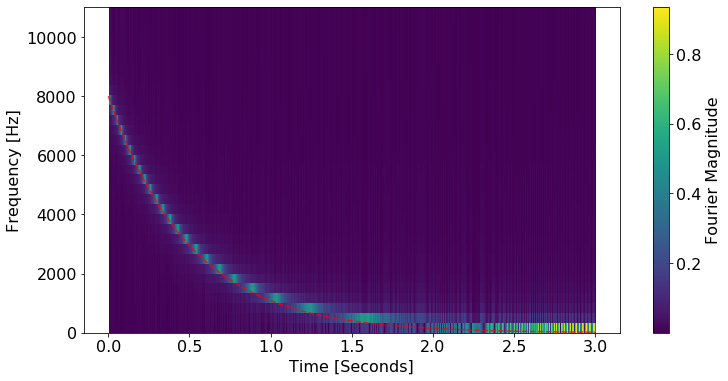

In [13]:
ess = ExponentialSpectralSummary(
    monitored_freqs=np.linspace(0, 11025, 33),
    alpha=1/64.0,
    dt=1/22050.0,
)

ess_spectra = monitor_spectrum(
    analyzer=ess,
    data=test_signal,
    monitoring_period=64,
    times=t,
)

plot_spectrogram(*ess_spectra)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);

This method seems to work just about as well as the sliding FT and requires only as much memory as it takes to keep the current spectrum estimate in memory, no need to keep a long history of updates to undue at a later time.

# Effective Window Size

Although it may not be immediately obvious we have to worry about all the same set of concerns about matching our set of monitored frequencies up to our effective window size. The alpha used in the exponential smoothing controls the effective window over which the spectrum is being estimated. 

$$
N_{eff} \approx \frac{1}{\alpha}
$$

A very large alpha will rapidly forget the past values and will not get good enough frequency resolution.

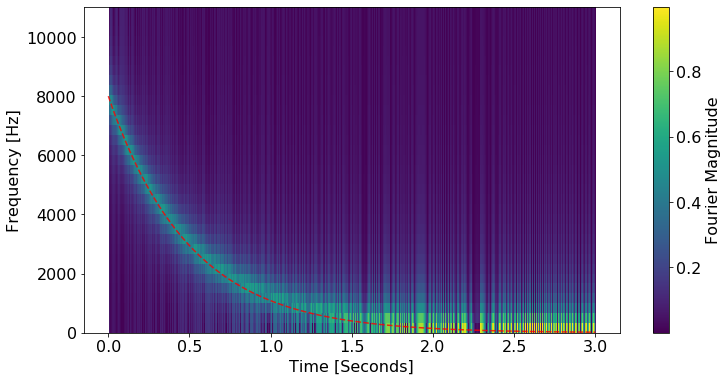

In [14]:
ess = ExponentialSpectralSummary(
    monitored_freqs=np.linspace(0, 11025, 33),
    alpha=1/10.0,
    dt=1/22050.0,
)

ess_spectra = monitor_spectrum(
    analyzer=ess,
    data=test_signal,
    monitoring_period=64,
    times=t,
)

plot_spectrogram(*ess_spectra)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);

And if we set the alpha to correspond to a memory wich is too long then we will get finer frequency resolution but that also means we must monitor a much larger suite of frequencies in order to avoid missing spectral power.

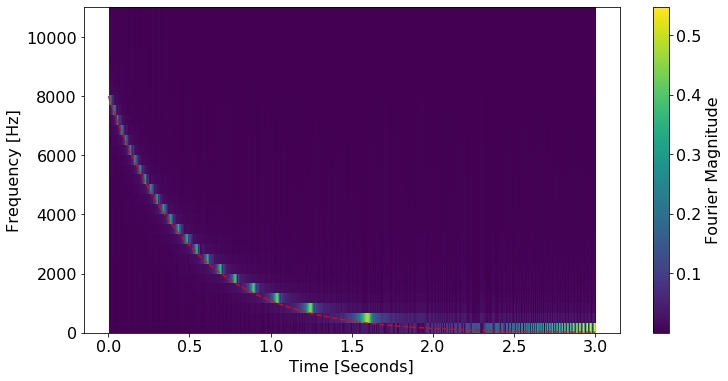

In [15]:
ess = ExponentialSpectralSummary(
    monitored_freqs=np.linspace(0, 11025, 33),
    alpha=1/256.0,
    dt=1/22050.0,
)

ess_spectra = monitor_spectrum(
    analyzer=ess,
    data=test_signal,
    monitoring_period=64,
    times=t,
)

plot_spectrogram(*ess_spectra)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);

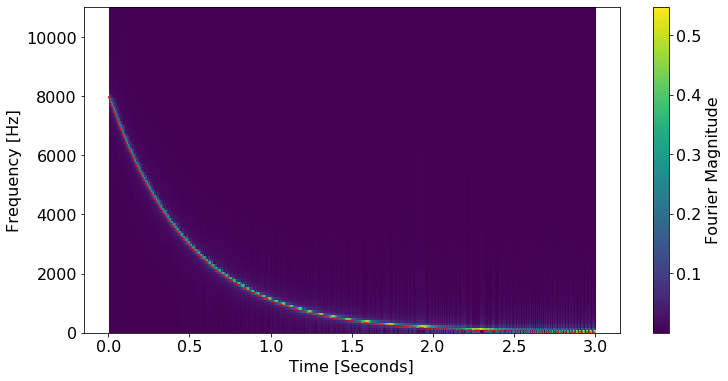

In [16]:
ess = ExponentialSpectralSummary(
    monitored_freqs=np.linspace(0, 11025, 128),
    alpha=1/256.0,
    dt=1/22050.0,
)

ess_spectra = monitor_spectrum(
    analyzer=ess,
    data=test_signal,
    monitoring_period=64,
    times=t,
)

plot_spectrogram(*ess_spectra)
plt.plot(t, f_of_t, color="r", linestyle="--", alpha=0.8);